# A4: Visual Question Answering

In this assignment, you'll gain experience working with multi-input models. You'll develop a model that takes a question and an image as input, and returns a yes/no answer in response. You'll also gain experience working with (and preprocessing) large datasets.

You are welcome to implement your model using either Model Subclassing or the Functional API. I suggest using the Functional API - it's worth gaining experience with, so you're familiar with it if you see it in code examples down the road. In either case, you will likely spend more time preparing and preprocessing the dataset, than you will developing the model.

## Your starter dataset

The [VQA dataset](https://visualqa.org/download.html) includes images and JSON containing the questions and answers. To save you time parsing the JSON (and various other preprocessing work), I've prepared a subset of the dataset in an easier to read CSV file. 

You should download your starter dataset from [here](https://storage.cloud.google.com/applied-dl/mini-vqa/starter2.csv). 

Your starter CSV has three columns, giving the question, answer, and image.

question|answer|image
:-----:|:-----:|:-----:
is the sky blue|yes|COCO\_train2014\_000000393221.jpg
is there snow on the mountains|yes|COCO\_train2014\_000000393221.jpg
is the window open|no|COCO\_train2014\_000000393223.jpg

### Notes on how this was prepared.
* The starter dataset contains all the "yes" / "no" questions from the VQA v2 training annotations. 
* The answers are the most frequent one to the question (ties broken randomly). 
* The text has been cleaned (lowercased, punctuation removed). 
* Each image and question is used exactly once.
* There are 140,637 questions, and 42,985 images.
* The image filenames correspond to the [COCO 2014 training images](http://images.cocodataset.org/zips/train2014.zip). Note this file is about 11GB. You will need to download this later.

### A note on downloading the COCO training images

The training images are large, and you may not want to download them repeatedly in Colab (e.g., if your instance resets, you will not want to have to download and preprocess an 11GB file all over again). Continue reading this assignment for tips.

In general, your workflow for this assignment will be to:

Part 1: 
- Create a notebook called "preprocessing.ipynb". In this notebook:
- Download the training images.
- Preprocess the images referenced in the starter CSV (e.g. by resizing them to 299x299). The starter CSV uses only a small fraction of the total images in the COCO dataset. You can disgard the unused images (e.g., by deleting them to free up disk space). 
- Create a zip file containing only the preprocessed images from the starter dataset (it should be about 500MB) and upload that to web.
- To upload a zip on the web, you can use any Cloud service (for example, [Cloud storage](https://cloud.google.com/storage/docs/creating-buckets)). Do not pay for a Cloud solution for this class (GCP, for example, has a free tier you can use).

Part 2:
- Complete this notebook, following the instrutions below.
- In this notebook, download your 500MB zip containing the preprocessed training images you created above using a command like ```!wget```, or the code shown below.

### A note on creating and training your model

You can find an example VQA model at the bottom of this [guide](https://keras.io/getting-started/functional-api-guide/). Note: you should start with a smaller model (in terms of vocabulary size,sequence length, and other parameters). 

Other changes: 
* Instead of training a CNN from scratch, you will use a pretrained model (Inception-V3) and cache activations to disk. 
* Your model will take a while to train. It is important that you save a [checkpoint](https://www.tensorflow.org/guide/keras/save_and_serialize) to disk after each epoch (or every several epochs). Before training your model, check for existing checkpoints, and load the latest one.

Training tips:

* When developing a complex model, it is important to fit on a single batch first (repeatedly train on the same batch of 32 examples and labels). Verify your model can successfully memorize this data (the loss should go to zero). For tips, see this excellent blog post: [A recipe for training NNs](http://karpathy.github.io/2019/04/25/recipe/).

* Next, write code to make predictions on each of these images, and to display the image, question, and answer. Make sure the results are sensible. 

* As always, start with a simple model, get that working end-to-end, then gradually scale up.

* Code defensively and get to know your data. There will be several preprocessing steps (resizing images, caching actiations, tokenization, padding, etc). After each one, write a short block of code to verify the output is correct.

## Starter code

The starter code below contains various blocks you can use for your two notebooks (the first to download and preprocess the data, the second to train your model).

## Submission instructions

Please submit this assignment on CourseWorks by uploading a zip containing your preprocessing notebook, and this file (both should include saved output).

In [ ]:
!pip install Pillow # used to resize images

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import pickle
import random
import shutil
import time

from google.colab import drive
from google.colab import auth
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
%matplotlib inline

In [ ]:
auth.authenticate_user()

## Notebook one: Download and preprocess the COCO training images
Create a new notebook called "preprocessing.ipynb" for this part of the assignment.

In this section, you will download your starter CSV and the COCO training images. Preprocess the +/- 40,000 images from the starter CSV (by resizing them to 299x299 using Pillow), and create a zip file called "thumbnails.zip". Your zip should be around 500MB. 

Finally, upload your "thumbnails.zip" to the Cloud, so you can easily download it in your second notebook.

### Tips

I recommend downloading the COCO images with curl, so you can resume your download if it is [interrupted](https://stackoverflow.com/questions/19728930/how-to-resume-interrupted-download-automatically-in-curl) or stalls.

In Colab (or on Linux / Mac):

```
$ curl -L -O your_url
```

You can download these images in Colab, but you may need to be mindful of disk usage. As a tip to save disk space, after unzipping them, you may delete any images from the zip not referenced in the starter code.

After you've downloaded them with curl, here's a command  you can use to unzip them:

```
$ unzip -q from_zip -d to_folder
```

Also note: there are so many images that opening the folder in the Colab will be slow. Instead of opening the folder with the UI, you can use these shell commands to explore it:

```
$ ls -lha
$ du -sh
```

### Download the starter CSV

In [ ]:
# Starter code to download small files
# Use this to download your starter CSV in notebook one and two.
# Also use it to download your thumbnails.zip in notebook two.
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
colab_root = "/content/"

In [ ]:
csv_path = os.path.join(colab_root, "starter2.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter2.csv",
                     csv_path)

1335296/1329146 [==============================] - 0s 0us/step


'/content/starter2.csv'

Tip. Here are a few shell commands you can use to quickly inspect the CSV and familiarize yourself with the format.

In [ ]:
!head $csv_path -n3 # take a look at a few rows

is this man a professional baseball player,yes,COCO_train2014_000000458752.jpg
is the dog waiting,yes,COCO_train2014_000000524291.jpg
is the sky blue,yes,COCO_train2014_000000393221.jpg


In [ ]:
!wc -l $csv_path

20000 /content/starter2.csv


### Download the COCO training images with curl

In [ ]:
!curl -L -O http://images.cocodataset.org/zips/train2014.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5G  100 12.5G    0     0  16.4M      0  0:13:02  0:13:02 --:--:-- 16.8M


In [ ]:
# Unzip them into a folder...afterwards, delete
# the zip file to reduce disk usage
!unzip -q ./train2014.zip -d ./

In [ ]:
!rm train2014.zip

In [ ]:
!ls ./train2014 -U | head -5

COCO_train2014_000000266990.jpg
COCO_train2014_000000489121.jpg
COCO_train2014_000000489497.jpg
COCO_train2014_000000387635.jpg
COCO_train2014_000000438691.jpg


In [ ]:
!ls ./train2014 -1 | wc -l

82783


Okay, we have 82,783 images in our dataset.

### Get to know your data.
Write code to display a few images, questions, and answers.

In [ ]:
# Your code here
# Next, familiarze yourself with the data. 
# Add code to display a few images from the training set using matplotlib,
# and their corresponding questions and answers from the starter CSV.
# Don't trust that your data is perfect (any bugs are unintentional 
# on my part, but there may well be some). The time you spend poking
# around with it is always a good investment.

# Read the data in...
starterCSV = pd.read_csv('starter2.csv', header=None,
                         names=['Question', 'Answer', 'Image'])
starterCSV.head()

,Question,Answer,Image
0,is this man a professional baseball player,yes,COCO_train2014_000000458752.jpg
1,is the dog waiting,yes,COCO_train2014_000000524291.jpg
2,is the sky blue,yes,COCO_train2014_000000393221.jpg
3,is the window open,yes,COCO_train2014_000000393223.jpg
4,is the man smiling,no,COCO_train2014_000000393224.jpg


We'll select 5 random datapoints and plot them to get a feel for the data.

is a bus stop visible: yes


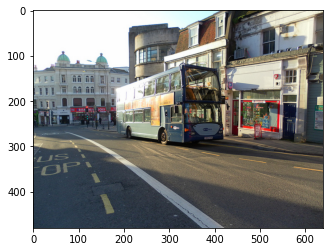

are most of the cows brown: no


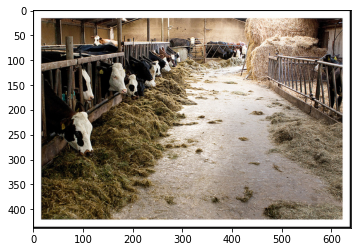

is anything on the fridge: yes


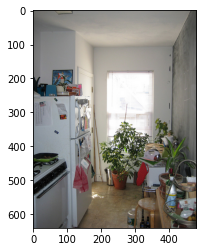

are they playing on grass: yes


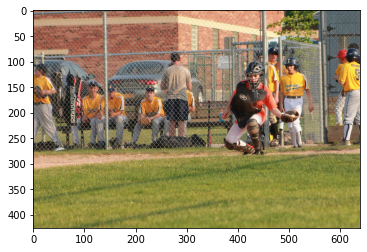

is this in iraq: no


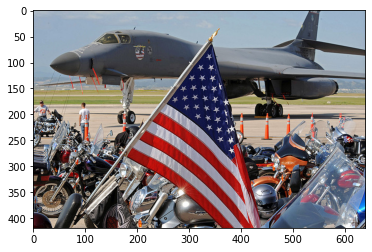

In [ ]:
numOfImgs = 5
sample = starterCSV.sample(numOfImgs)
directory = 'train2014'
# Iterate through the rows, printing
# the question, answer, and plotting the image.
for _, rowData in sample.iterrows():
  question = rowData['Question']
  answer = rowData['Answer']
  imagePath = rowData['Image']
  img = mpimg.imread(os.path.join(directory, imagePath))
  print('{}: {}'.format(question, answer))
  plt.imshow(img)
  plt.show()

### As a sanity check, verify you can locate all the images
Write code to verfy you can find every image mentioned in your starter CSV (in the unzipped COCO images).

In [ ]:
# Your code here
# Next, write code to verfy you can find every image mentioned in the starter 
# CSV on disk. For example, you may want write a loop like this:
# import csv
# with open('starter2.csv') as myfile:
#    reader = csv.reader(myfile, delimiter=',')
#    for row in reader:
#       question, answer, image = row
#       image = image.strip()
#       assert os.path.exists(os.path.join(coco_images_folder, image))

In [ ]:
# Loop through the 'Image' column
for imagePath in starterCSV.Image:
  assert os.path.exists(os.path.join(directory, imagePath))

No output means all asserts evaluated to true, so we're fine.

### Resize the images to 299x299
Next, resize the images referenced in your starter CSV to 299x299 using Pillow.

### Tips
Here is code you can use to create a thumbnail of an image.

```
size = 299, 299
im = Image.open(path_to_image)
im.thumbnail(size)
out_file = os.path.join(your_directory, image_name)
im.save(out_file, "JPEG")
```

Note: do not change the image names when saving (your rezied image names should exactly match the names in the starter code).

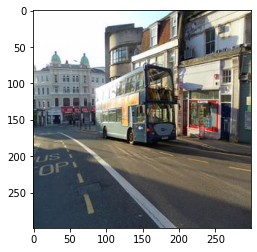

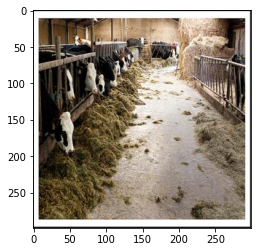

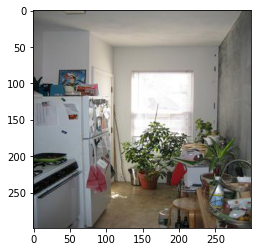

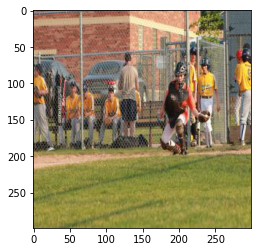

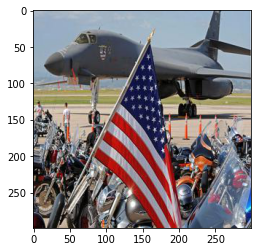

In [ ]:
# Resize all the images in the starter CSV to 299x299.
# Display a few and make sure the resize is working as expected.

# Create a separate directory starterTrain
# to hold our resized images. Then we can just
# delete the old folder entirely.
starterFolder = 'starterTrain'
os.makedirs(starterFolder, exist_ok=True)
# Use the same images from before to show the resizing...
size = 299, 299
for imagePath in starterCSV.Image:
  im = Image.open(os.path.join(directory, imagePath))
  im = im.resize(size)
  im.save(os.path.join(starterFolder, imagePath), 'JPEG')

# Select a sample of images to plot to make sure 
# it worked...
for imagePath in sample.Image:
  im = Image.open(os.path.join(starterFolder, imagePath))
  plt.imshow(np.asarray(im))
  plt.show()

Okay, so it looked like the image resizing worked as expected. Since we resized the ones we wanted and placed them in another directory, we can simply remove the original `train2014` folder to free up disk space. Before we do that, let's double check to make sure we can still locate all images in the dataset in `starterTrain`.

In [ ]:
# Your code here
# Delete all images not mentioned in the starter CSV.
# As before (as a sanity check) make sure you can still locate every image 
# (now resized) mentioned in your starter CSV.
for imagePath in starterCSV.Image:
  assert os.path.exists(os.path.join(starterFolder, imagePath)) # <-- New folder

No output for assert, so we're good to go!

In [ ]:
!rm -r ./train2014

### Create a zip of your resized images

### Tips
Here is code you can use to zip a directory, creating a new zip file "thumbnails.zip"

```
shutil.make_archive('thumbnails', 'zip', [directory_to_zip])
```

In [ ]:
# Your code here
# Create a thumbnails.zip
# Verify the size is around 500MB
shutil.make_archive('starterTrain', 'zip', root_dir='starterTrain')
print('File Size: {} MB'.format(os.path.getsize('starterTrain.zip') // (1024 ** 2)))

File Size: 344 MB


The file size is about 344 MB, so we can upload it safely.

### Upload your thumbnails.zip to the Cloud

You want to host your thumbnails.zip file at a URL, for example: ```https://storage.googleapis.com/[your_bucket_name]/thumbnails.zip```, so you can easily download it in your second notebook.

You can use any Cloud provider. Google Cloud [storage buckets](https://cloud.google.com/storage/docs/creating-buckets) are fine for this. You can use the [free tier](https://cloud.google.com/free/).

After this is done, you're ready to start on notebook two.

I'll use Google Cloud Storage for storing the zip file, as it is well under the free tier limit and it's simple to connect Colab to GCS. My user account has already been authenticated at the top. The command line utility `gsutil` will upload it directly to a bucket called `coms4995_data`.

In [ ]:
# We need my project ID to connect
projectID = 'baseproject-270715'

In [ ]:
!gcloud config set project {projectID}
!gsutil ls

Updated property [core/project].
gs://coms4995_data/


In [ ]:
bucketName = 'coms4995_data'
!gsutil cp ./starterTrain.zip gs://{bucketName}/

CommandException: No URLs matched: ./starterTrain.zip


It's uploaded, which now means we don't have to run through this preprocessing over again in case we get cut-off from the instance.

## Notebook two: Preprocessing and training
Create a new notebook for this. At the start, download your starter CSV and thumbnails.zip.

The starter code below assumes you have created a zip file called "thumbnails.zip" containing only the resized images from the COOC training set mentioned in the starter CSV, and that you can download it from a URL.

In [ ]:
colab_root = "/content/" 

### Download the starter CSV

In [ ]:
csv_path = os.path.join(colab_root, "starter2.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter2.csv",
                     csv_path)

'/content/starter2.csv'

### Download and unzip your thumbnails

This file is small enough that you can quickly download it with this method.

In [ ]:
bucketName = 'coms4995_data'
zipfileName = 'starterTrain.zip'
imagesFolder = 'csvImages'
!gsutil cp gs://{bucketName}/{zipfileName} ./{zipfileName}
!unzip -q $zipfileName -d $imagesFolder
!ls $imagesFolder -U | head -5

Copying gs://coms4995_data/starterTrain.zip...
\ [1 files][344.3 MiB/344.3 MiB]                                                
Operation completed over 1 objects/344.3 MiB.                                    
replace csvImages/COCO_train2014_000000266990.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
ls: cannot access './{csvImages}': No such file or directory


### Sanity check

At this point, you have all the data you need to train your model (questions, answers, and images) in a convenient and easy to read format. 

Now would be a good time for another santity check. Write a block of code to iterate over the starter CSV file. For each image, make sure you can locate it on disk. E.g., 

``` 
for question, answer, image_name in data:
  img_path = os.path.join(images_folder, image_name)
  assert os.path.exists(img_path)
```

Since we're in a new notebook, again display a few questions, answers, and images - verify everything works as expected.

is the girl on a laptop: no


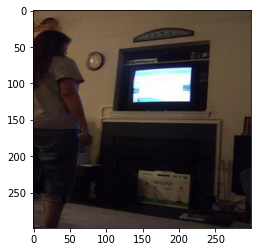

are the sheep behaving: yes


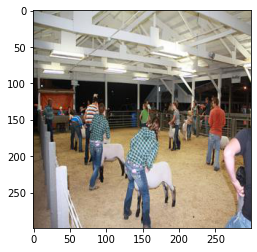

is the mans hair messing: no


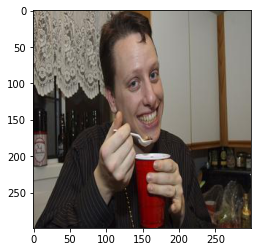

is this picture from the 21st century: no


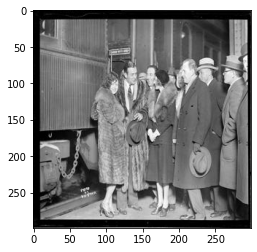

are they working: yes


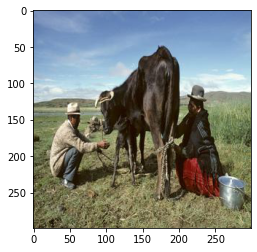

In [ ]:
starterCSV = pd.read_csv('starter2.csv', header=None,
                         names=['Question', 'Answer', 'Image'])
numOfImgs = 5
sample = starterCSV.sample(numOfImgs)
directory = 'csvImages'
# Iterate through the rows, printing
# the question, answer, and plotting the image.
for _, rowData in sample.iterrows():
  question = rowData['Question']
  answer = rowData['Answer']
  imagePath = rowData['Image']
  img = mpimg.imread(os.path.join(directory, imagePath))
  print('{}: {}'.format(question, answer))
  plt.imshow(img)
  plt.show()

### Convert answers to numeric format

The answers in the starter CSV are "yes" or "no". For convenience, now would be a good time to change those to 1.0 and 0.0.

In [ ]:
# Your code here
# Convert the answers column in the starter CSV to 1.0 and 0.0
# You do not need to update the CSV itself. If you have a data structure
# in memory, you can work with that instead.
yesLocs = starterCSV.Answer == 'yes'
starterCSV.loc[yesLocs, 'Answer'] = 1.0
starterCSV.loc[~yesLocs, 'Answer'] = 0.0
starterCSV.Answer = starterCSV.Answer.astype(float)
starterCSV.head()

,Question,Answer,Image
0,is this man a professional baseball player,1.0,COCO_train2014_000000458752.jpg
1,is the dog waiting,1.0,COCO_train2014_000000524291.jpg
2,is the sky blue,1.0,COCO_train2014_000000393221.jpg
3,is the window open,1.0,COCO_train2014_000000393223.jpg
4,is the man smiling,0.0,COCO_train2014_000000393224.jpg


### Convert image names to absolute paths

Next, for convenience, it may be helpful to update the images column in the starter CSV from filenames ```COCO_train2014_000000320111.jpg``` to absolute paths ```/content/images/COCO_train2014_000000320111.jpg```. This will save you some code down the road when it comes time to open them up (you won't need to worry about the relationship between where the starter CSV file is stored, and your images folder).

In [ ]:
# Your code here
# Convert the image filenames in the starter CSV to absolute paths
# You do not need to update the CSV itself. If you have a data structure
# in memory, you can work with that instead.

# One line for the win!
starterCSV.Image = '/content/csvImages/' + starterCSV.Image
starterCSV.head()

,Question,Answer,Image
0,is this man a professional baseball player,1.0,/content/csvImages/COCO_train2014_000000458752...
1,is the dog waiting,1.0,/content/csvImages/COCO_train2014_000000524291...
2,is the sky blue,1.0,/content/csvImages/COCO_train2014_000000393221...
3,is the window open,1.0,/content/csvImages/COCO_train2014_000000393223...
4,is the man smiling,0.0,/content/csvImages/COCO_train2014_000000393224...


### Shuffle and create a test set
For this assignment, you do not need to download the COCO validation or test sets. Instead, shuffle your starter CSV, and use some of the rows as a test set (say, 4,000 rows). Move them to a separate CSV or data structure, and revisit them later. I realize some of the same images may appear in the train and test set (although with different questions). For this assignment, that's okay. If you prefer, you can write code to ensure the test set has unique images that do not appear in the train set.

In [ ]:
# Your code here
# Shuffle the starter CSV
# Remove 4,000 rows (or so) and move them to a separate file or data structure

# Shuffle, then randomly sample 4000 rows...
from sklearn.model_selection import train_test_split
starterCSV, testData = train_test_split(starterCSV, test_size=4000)
testData.to_csv('./test.csv', index=None)
testData.head()

,Question,Answer,Image
13297,is there a person on the couch,0.0,/content/csvImages/COCO_train2014_000000422894...
9558,will the boy on the right be able to eat all o...,1.0,/content/csvImages/COCO_train2014_000000309260...
14819,is he wearing a sash,0.0,/content/csvImages/COCO_train2014_000000557811...
15518,are those dress shoes,0.0,/content/csvImages/COCO_train2014_000000202511...
7561,are they both skating,0.0,/content/csvImages/COCO_train2014_000000278028...


### Limit the size of the dataset, and balance

**Update: the starter dataset you downloaded is already balanced. You can skip this step**

*Limit the size of the dataset, and balance. The dataset is fairly large. Let's simplify and start small. Instead of working with +/-100,000 questions, a better number would be about 20,000. As a suggestion, you may also want to balance the data (so you have an equal number of positive and negative questions), just to make it a bit easier to debug your model and verify it's training as expected. italicized text*

In [ ]:
# You can skip this step.
# Your code here
# Limit the size of the starter CSV to 20,000 rows
# Balance the data (so you have an equal number of "yes" and "no" answers) 
# in your 20,000 rows

### Create training and validation sets
You may want to do an 80:20 split on your balanced training set, giving you 16,000 training rows, and 4,000 validation rows.

In [ ]:
# Your code here
# The scikit-learn utilities (train_test_split) are your friend
trainData, valiData = train_test_split(starterCSV, test_size=0.2)
print('Training shape:', trainData.shape)
print('Validation shape:', valiData.shape)

Training shape: (12800, 3)
Validation shape: (3200, 3)


### Verify your train and validation sets look as expected
You cannot spend too much time exploring the data. When I'm developing code for something like this on my own, I often run methods to verify that these splits have the number of rows I expect, to display a few images from each, and to see stats on the class balance. I also write code to verify the splits contain *only* yes/no answers. You may be tired of coding defensively at this point, but I assure you (especially when working with new and increasingly complicated datasets, this effort **always** pays off).

Training
do americans usually render and consume many of these creatures: 0.0


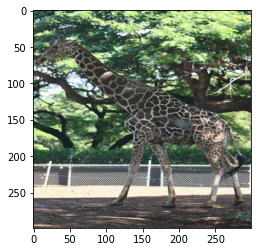

does the man have a watch: 1.0


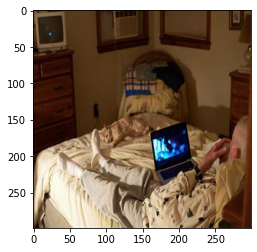

is this an artificial birthday cake: 0.0


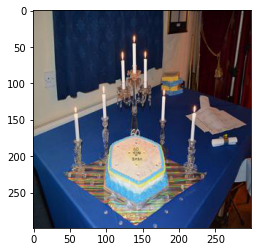

is the man playing basketball: 0.0


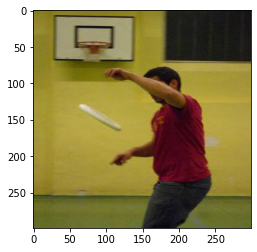

is she on a grass court: 0.0


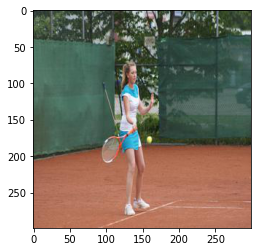

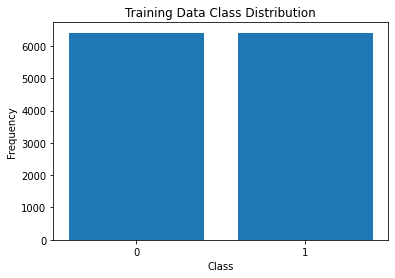

Validation
are the bears in a cage: 1.0


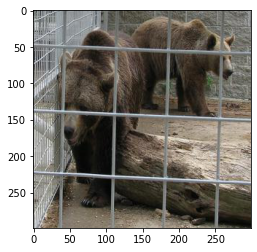

is the dog riding a skateboard: 0.0


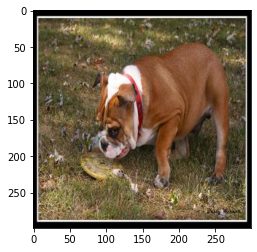

is there any humans seen: 1.0


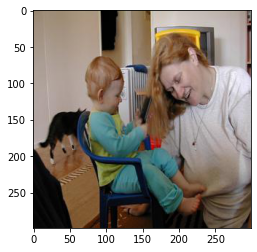

is the person in the background wearing sunglasses: 0.0


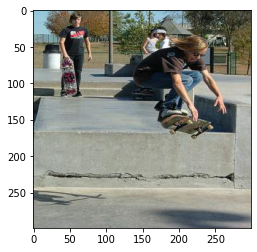

can you eat this fruit: 1.0


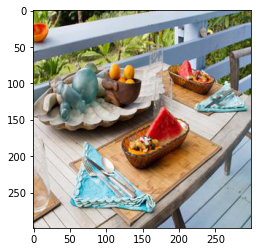

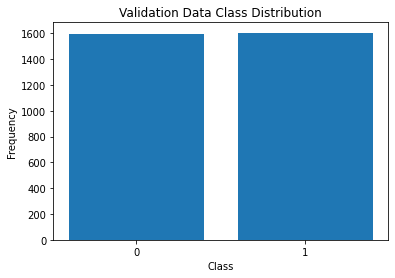

In [ ]:
from collections import Counter
# Your code here.
# Display 5 training and validation images and their questions....
sampleAmount = 5
dataLabels = ['Training', 'Validation']
for label, data in zip(dataLabels, [trainData, valiData]):
  print(label)
  sample = data.sample(sampleAmount)
  for _, rowData in sample.iterrows():
    question = rowData['Question']
    answer = rowData['Answer']
    imagePath = rowData['Image']
    img = mpimg.imread(imagePath)
    print('{}: {}'.format(question, answer))
    plt.imshow(img)
    plt.show()
  # Show class distribution
  c = Counter(data.Answer)
  c = sorted(c.items())
  values = [item[0] for item in c]
  freqs = [item[1] for item in c]
  f, ax = plt.subplots()
  plt.bar(values, freqs)
  plt.title('{} Data Class Distribution'.format(label))
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  ax.set_xticks([0, 1])
  ax.set_xticklabels([0, 1])
  plt.show()


### Forward your images through InceptionV3, and cache activations to disk

Rather than training a CNN from scratch for your VQA model, you'll begin by using activations from a pretrained model.  

* Instead of forward each image repeatedly through the model while training (which will be slow), let's do that once and save the activations to disk. 

* We're saving them to disk (rather than keeping them in memory) to accomodate different sizes of datasets down the road.

I've written a good deal of this code for you, but you should go through it and carefully understand how it works.

In [ ]:
# Create a feature extraction model.
# You should not need to modify this (though you may, if you'd like
# to use a model other than Inception).
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# A method to load an image off disk, and extract activations using 
# the model above. You should not need to modify this.
def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations, image_path

In [ ]:
# Your code here

# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images 
# (image_path_set). Populate this with the absolute paths to all these images.
image_path_set = set(pd.concat([trainData.Image, valiData.Image, testData.Image]))


print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 20000
This make take a few minutes


In [ ]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. You should not need to modify this.

# Note: we're not saving these activations to the cloud,
# but you certainly could if you wanted to skip this step 
# in the future. If you look into doing that, it's best to save one large
# zip with the activations, and download that and extract it locally
# (rather than doing a bunch of network access to retrieve individual files),
# especially when training your model.

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

### Create lists of questions, answers, and images for your train, validation, and test set

At this point, you may be reading your starter CSV directly from disk, or you may have your own data structure in memory. Since many of the methods we'll call from this point forward take lists as input, you may find it helpful to create a data structure with three lists, that correspond to the columns from your starter CSV.

In [ ]:
# Your code here. Populate these for your training set.
questions_train = trainData.Question.tolist() # a list of absolute paths to images in your training set
answers_train = trainData.Answer.tolist() # a list of questions in your training set
images_train = trainData.Image.tolist() # a list of answers (in numeric format) in your training set

# The order of these lists should match (e.g. the question, answer, and image 
# from row i of your train split of the starter CSV should be 
# questions_train[i], answers_train[i], images_train[i]).

In [ ]:
# Your code here. Populate these for your validation set.
questions_val = valiData.Question.tolist()
answers_val = valiData.Answer.tolist()
images_val = valiData.Image.tolist()

In [ ]:
# Your code here. Populate these for your test set
questions_test = testData.Question.tolist()
answers_test = testData.Answer.tolist()
images_test = testData.Image.tolist()

### Create and fit a tokenizer

Your model will use a LSTM to process the questions. First, you'll need to vectorize your text. Tokenize the questions, and limit the vocabulary size to a reasonable size (for example, the top 3,000 words). A larger size will make a higher accuracy possible, but complicate and slow your model. Reminder: fit the tokenizer only on the training questions.

In [ ]:
# Your code here
VOCAB_SIZE = 3500

In [ ]:
# You should not need to modify this code
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions_train)

# Note, the tokenizer's word_index will not respect VOCAB_SIZE.
# but, that parameter will be respected in later methods,
# (for example, when you call text_to_sequences).
# Also note that '0' is a reserved index for padding.
print("Word index", len(tokenizer.word_index))

Word index 4940


### Vectorize the questions
In this section, you will use your tokenizer to vectorize the questions using ```texts_to_sequences```. For an example of texts_to_sequences, see this [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-one-hot-encoding-of-words-or-characters.ipynb).


In [ ]:
# Your code here
# Use the texts_to_sequences utility to vectorize your training, 
# validation, and test questions. 

# To follow along with the starter code below, you should use
# these naming conventions

sequences_train = tokenizer.texts_to_sequences(questions_train)
sequences_val = tokenizer.texts_to_sequences(questions_val)
sequences_test = tokenizer.texts_to_sequences(questions_test)

### Pad sequences

In this section, you will pad the vectorized questions using ```pad_sequences```. Your maximum sequence length is a design decision, just like vocab size. Advice, start with something short, so your model trains faster (maybe, between 10 and 20).

For an example of pad_sequences, see this [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb).

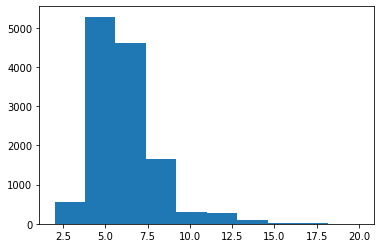

In [ ]:
# Your code here
# To choose a reasonable sequence length, examine the length of all the 
# tokenized questions in the training set (in words).
# Justify your choice, e.g. you should note that percentage of the 
# training questions that fall under that length (and will not be trimmed), 
# and the number of questions that will be.

# Let's see a histogram of word lengths...
plt.hist([len(seq) for seq in sequences_train])
plt.show()

It appears that most questions are 5-8 words long, but there are enough questions that are more than them to warrant having a higher word length. I would say probably 13 words is a good stopping point.

In [ ]:
# Your code here
MAX_SEQ_LEN = 13

In [ ]:
# Your code here
# Use the pad_sequences utility to pad your training, 
# validation, and test questions.

# To follow along with the rest of the statter code, you can use these
# naming conventions

padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, maxlen=MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LEN)

### Sanity check
You've just done a **bunch** of preprocessing. Optionally, now would be a good time to write a block of code to verify the tokenized and padded sequences are in the format you expect.

In [ ]:
# Your code here (optional).
# Since you have a word_index from the tokenizer, you may 
# also want to write code to convert from a vectorized question
# back to a string.
print('Shapes of Padded Datasets (should all have 13 columns)...')
print('Padded Train:', padded_train.shape)
print('Padded Validation:', padded_val.shape)
print('Padded Test:', padded_test.shape)

print('Sample questions...')
print('Training question:', ' '.join([tokenizer.index_word[i] for i in sequences_train[0]]))
print('Validation question:', ' '.join([tokenizer.index_word[i] for i in sequences_val[0]]))
print('Testing question:', ' '.join([tokenizer.index_word[i] for i in sequences_test[0]]))

Shapes of Padded Datasets (should all have 13 columns)...
Padded Train: (12800, 13)
Padded Validation: (3200, 13)
Padded Test: (4000, 13)
Sample questions...
Training question: is the man reverting back to childhood
Validation question: is there a person next to the train
Testing question: is there a person on the couch


### Create a tf.dataset for training, validation, and testing

The method to create the dataset is provided for you, though you will need to get it working by passing the ```padded_train```, ```answers_train``` ```and images_train``` lists you created above.




In [ ]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
# You should not need to modify this.
# Load cached activations off disk.
def load_np(img_path, question, answer):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, question, answer, img_path

In [ ]:
# You should not need to modify this.

# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of padded questions
# - a batch of numeric answers
# - a batch of absolute paths to the corresponding images
def create_dataset(images, sequences, answers):
  dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                sequences, 
                                                answers))
  # TODO jbgordon@: rewrite this to be clearer
  # Load the cached activations off disk
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.int32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
# Your code here

# Call the above method to create train, val, and test datasets.
# If you want to follow along with the starter code, I suggest these
# variable names:

train_ds = create_dataset(images_train, padded_train, answers_train)
val_ds = create_dataset(images_val, padded_val, answers_val)
test_ds = create_dataset(images_test, padded_test, answers_test)

### Sanity check (optional)
That dataset creation method is complicated. Write a block of code that demonstrates how to use the dataset (e.g., retrieve a batch of activations, questions, answeres, and images paths) and verify they look as expected.

In [ ]:
# Your code here (optional)
# Verify your datasets are working properly

# Here is code you can use to quickly retrieve a batch of data

my_iterator = iter(train_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      questions_batch.shape, 
      answers_batch.shape, 
      paths_batch.shape)

# print(activations_batch, 
#       questions_batch, 
#       answers_batch, 
#       paths_batch)

(32, 8, 8, 2048) (32, 13) (32,) (32,)


### Define your VQA model

You can base your code off the example give toward bottom of this [guide](https://keras.io/getting-started/functional-api-guide/) (but use a smaller model to start). Aim for a couple hundred thousand parameters or so

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.models import Model, Sequential

In [ ]:
# Your code here
# Below is starter code for your model for you to complete.
# See https://keras.io/getting-started/functional-api-guide/ for the idea.
# The vision model is written for you. You will need to write the question
# model.

embedDim = 100
lstmNodes = 50
denseNodes = 30

# Input to your vision model (activations from Inception-V3,
# loaded off disk disk by the dataset above).
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 

# Your code here
# Write your test processing model that takes the vectorized and padded
# question as input.
# As in the guide above, you will want to produce an `encoded_question`
# as output
question_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name='questIn')
embedded_question = Embedding(output_dim=embedDim, input_dim=VOCAB_SIZE, input_length=MAX_SEQ_LEN)(question_input)
encoded_question = LSTM(lstmNodes)(embedded_question)

# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

# Optionally, add a small dense layer
dense = Dense(denseNodes)(merged)

# Next, add a binary classifier on top
output = Dense(1, activation='sigmoid')(dense)

# Your final model
model = Model(inputs=[image_input, question_input], outputs=output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questIn (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13, 100)      350000      questIn[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Plot your model
Create a schematic that shows the graph of your model, using [plot_model](https://keras.io/visualization/). This can be helpful to ensure the vision and question paths look at expected (it's also super cool, and more informative than .summary).

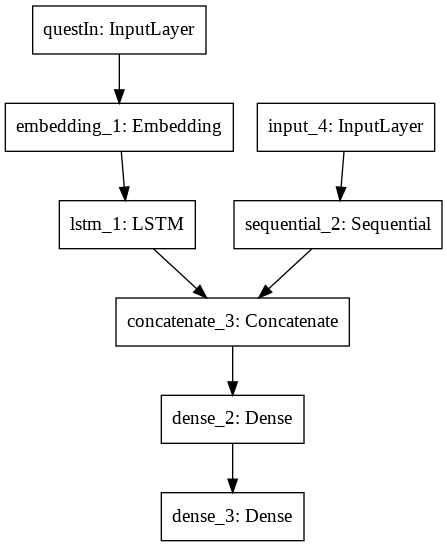

In [ ]:
# You should not need to modify this.
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Fit your model on a single batch
Before training on your entire dataset, a helpful first step is to train repeatedly on a single batch, and verify the loss goes to zero. If your model is working properly, it should be able to memorize a batch of data. We will use ```model.train_on_batch``` for this.

In [ ]:
# You should not nee to modify this.
# Retrieve a batch of data from your train dataset
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

In [ ]:
# Your code here

# Train them model repeatedly using model.train_on_batch
# Verify the loss goes to zero after +/- 100 training steps.
# If it does not, now would be a great time to debug 
# before proceeding further.

# e.g.
# metrics = model.train_on_batch()
# metrics is a list (loss is metrics[0], accuracy is metrics[1])
losses = []
accuracies = []
for _ in range(100):
  metrics = model.train_on_batch(x=[activations_batch, questions_batch],
                                 y=answers_batch)
  losses.append(metrics[0])
  accuracies.append(metrics[1])

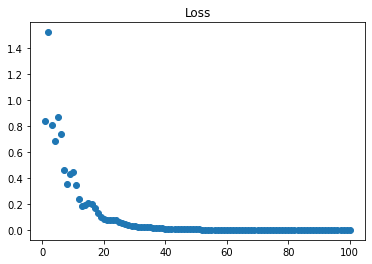

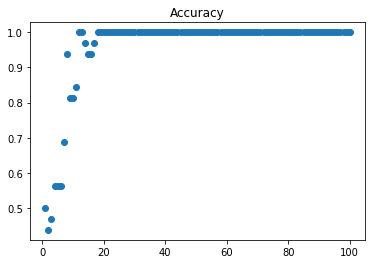

In [ ]:
plt.scatter(x=list(range(1, 101)), y=losses)
plt.title('Loss')
plt.show()
plt.scatter(x=list(range(1, 101)), y=accuracies)
plt.title('Accuracy')
plt.show()

Both the loss is decreasing and the accuracy quickly got to 100%, so the model is working properly. Let's compile again so that these are erased.

### Use your model to make predictions on the same batch above
Compare the predicted answer to the label. Verify they match.

In [ ]:
# You should not need to modify this, but you will want to 
# carefully inspect the output.
for prediction, answer in zip(model.predict(x=[activations_batch, questions_batch]), answers_batch):
  print(prediction, answer.numpy())

[0.00031487] 0.0
[1.4628329e-05] 0.0
[4.6095425e-05] 0.0
[2.8003838e-05] 0.0
[0.00037163] 0.0
[0.0002659] 0.0
[0.99878997] 1.0
[0.00015361] 0.0
[0.00095081] 0.0
[0.9999697] 1.0
[0.00016498] 0.0
[0.999493] 1.0
[0.00032433] 0.0
[0.99972075] 1.0
[0.99984014] 1.0
[0.99998784] 1.0
[3.7326514e-05] 0.0
[0.00063532] 0.0
[0.00053657] 0.0
[0.99986446] 1.0
[0.9999472] 1.0
[0.00018263] 0.0
[0.9994566] 1.0
[0.9997938] 1.0
[8.184819e-05] 0.0
[0.00011332] 0.0
[0.99996674] 1.0
[9.524238e-05] 0.0
[0.9999448] 1.0
[0.00087906] 0.0
[0.9997836] 1.0
[0.9989743] 1.0


### Create a checkpoints directory

Once you have been able to train your model on a single batch, it's time to begin training on your training dataset. It may take a while to train for a single epoch, and it would be unfortunate if Colab disconnected after training for a while, and you lost your progress.

* After each training epoch, save the model's weights in a checkpoint file. You can learn more about how to create checkpoints [here](https://www.tensorflow.org/guide/keras/save_and_serialize). 

* To resume training, load the latest checkpoint from disk. This will restore the latest weights and resume your progress. If it does not exist, begin training from scratch.

* As a tip, you may want to store your checkpoints in Google Drive, so you'll still have access to them if Colab disconnects. 

Note that running long jobs is not what Colab is intended for. Normally, you could simple save your checkpoints on the machine you're working on. Saving to drive adds an extra step, but it's worthwhile learning how to do.

Tip: after mounting Drive, **do not** programmatically run any commands to delete files from your checkpoints folder or elsewhere (e.g., by using ```!rm -rf```) in Colab. If you're not careful, you may accidentally wipe out your entire drive if you make a programming mistake. 

* Instead, if you need to delete checkpoints, do so manually through the drive user interface. Note that files deleted through the UI may take a minute or so to "actually" be deleted as reflected by ```!ls``` commands run from Colab.

In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# If you'd like to save checkpoints in drive, you will need to uncomment
# the code below. Alternatively, you can modify it to save
# checkpoints in Colab (these will not persist if your instance is terminated,
# but you can manually download them if you like).
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "hw4")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [ ]:
# Your code here
# Uncomment this if you'd like to create a checkpoints folder in your drive
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/checkpoints/hw4
Creating a checkpoints directory


### Restore the latest checkpoint (if it exists).

In [ ]:
# You should not need to modify this code.
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Metrics

In [ ]:
# Utilities to help us record metrics.
# You should not need to modify this code
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Code to evaluate on the validation dataset
The validation dataset may be large. It would be wasteful to evaluate on the entire validation dataset each training epoch. Instead, you could evaluate every N epochs, or, you can use the below methoid to evaluate for a fixed number of steps (batches). This will give you a noisier evaluation, but a useful indicator of how your model is doing over time.

In [ ]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

### Train the model
As before, we'll write our training loop using ```train_on_batch```. This is intermediate in complexity between using ```.fit``` and writing everything from scratch using a ```GradientTape```. Because we're not using ```.fit```. Since we're not using .fit, there's a bit of extra code we need to write ourselves to track loss and accuracy as we go.

In [ ]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 2 # Your code here

# Training loop
for epoch in range(1, epochs + 1):

  start = time.time()

  # Train for one epoch
  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result().numpy())
  train_acc_history.append((train_accuracy.result() * 100).numpy())
  val_loss_history.append(val_loss.result().numpy())
  val_acc_history.append((val_accuracy.result() * 100).numpy())

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")

  model.save_weights(os.path.join(checkpoint_dir, 'modelWeightsEpoch{}.h5'.format(epoch)))

Epoch 1, Loss: 0.46, Accuracy: 76.06, Val Loss 0.97, Val Accuracy 51.81, Time: 19.4 secs
Saving weights
Epoch 2, Loss: 0.43, Accuracy: 77.22, Val Loss 1.01, Val Accuracy 52.72, Time: 19.6 secs
Saving weights


### Create plots of your training and validation loss and accuracy

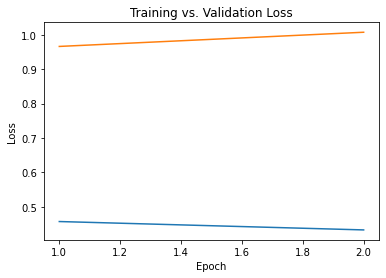

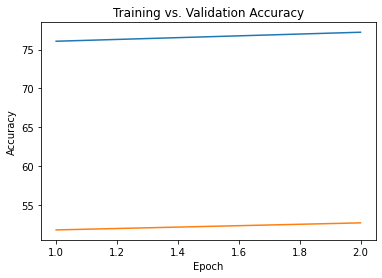

In [ ]:
# Training and Validation loss...
epochArray = list(range(1, epochs + 1))
plt.plot(epochArray, train_loss_history, '-')
plt.plot(epochArray, val_loss_history, '-')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epochArray, train_acc_history, '-')
plt.plot(epochArray, val_acc_history, '-')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### At this point, you have end-to-end code to train VQA model
Now you can begin working on increasing accuracy. For this assignment, your model should at least be able to fit your training split reasonably well. 

Given the amount of data we're using, you do **not** need to build a model that performs well on validation to receive full credit for this asignment (I recently made the starter dataset a bit more difficult, as a result - you may need to train using more data than I want you to use for a homework assignment, so no worries).

### Writen response
How would you improve the accuracy on the validation set? Please list three ideas below.

#### TODO: your answer here

1. There could be words in the validation that aren't in the training, so accounting for "unknown" words could be useful.
2. Using a pre-trained embedding like GloVe, which already has robust word relationships.
3. Distorting images like in previous assignments could also be useful. Though you have to be careful, since these questions were asked to actual people. Distorting it beyond recognition could render the question useless.

### Finally, evaluate your model on the test set
How well did it do? This assignment is lengthy. For our purposes, it's fine to report the accuracy - and you're done :) 

For a proper evaluation, take a look at this [paper](https://arxiv.org/abs/1612.00837), as discussed in class.

Note: if your model is performing poorly on the test set, you can still receive full credit for this assignment as mentioned above. 

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

In [ ]:
# Your code here
# Calculate accuracy on the test set

Phew, that's it! This was a long assignment, I hope it was a useful (and fun!) experience.